In [1]:
%matplotlib inline

from pathlib import Path
from json import dumps
import string
import numpy as np
from scipy.signal import fftconvolve
from matplotlib import pyplot as plt
import pandas as pd

from bioread import read_file

plt.rcParams["figure.figsize"] = (20, 2.5)

In [2]:
DATA_PATH = Path("/data/datasets/hcph-pilot-sourcedata/recordings/BIOPAC")
BIDS_PATH = Path("/data/datasets/hcph")

participant = "001"
session = "001"
pe = "LR"

In [3]:
session_data = read_file(str(DATA_PATH / "session2023-10-20T18:06:05.acq"))
channels = session_data.channels

In [4]:
freq = session_data.channels[4].samples_per_second
timeseries = session_data.channels[4].time_index

freq, len(timeseries)

(5000.0, 42310569)

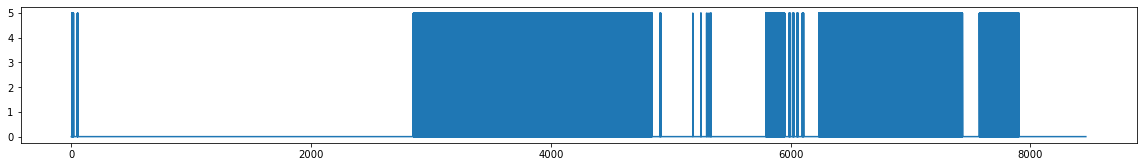

In [5]:
plt.plot(timeseries, session_data.channels[4].data);

(2800.0, 5000.0)

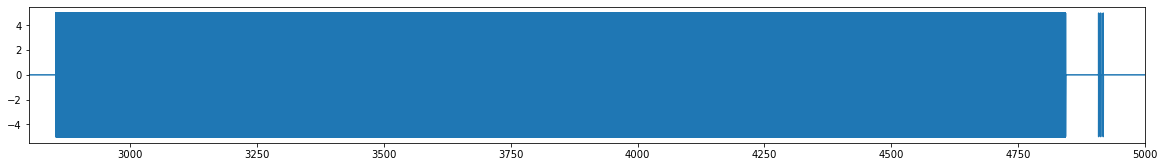

In [6]:
data = session_data.channels[4].data

trigger_events = np.hstack((0, np.diff(data)))
plt.plot(timeseries, trigger_events)
plt.xlim((2800, 5000))

(2852.98, 2854.0)

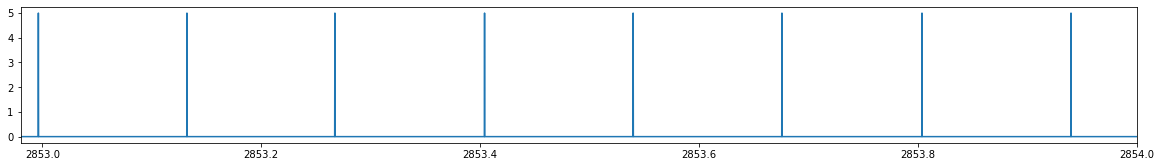

In [7]:
trigger_onsets = trigger_events.copy()
trigger_onsets[trigger_onsets < 0] = 0
plt.plot(timeseries, trigger_onsets)
plt.xlim((2852.98, 2854))

In [8]:
trigger_locations = np.hstack((0, np.argwhere(trigger_onsets > 0)[:, 0]))
trigger_spacings = np.diff(trigger_locations)

# 120s is 2m (the shortest task, QCT)
between_seq = trigger_locations[1:][trigger_spacings > freq * 120]
between_seq = np.delete(between_seq, 1)
seq_limits = np.zeros_like(trigger_onsets)
seq_limits[between_seq] = 1
print(len(between_seq))

4


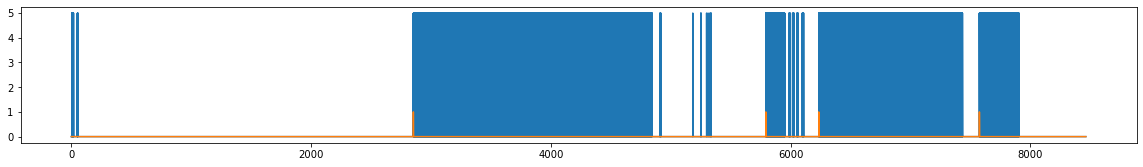

In [9]:
plt.plot(timeseries, trigger_onsets);
plt.plot(timeseries, seq_limits);

In [10]:
seq_onsets = [timeseries[i] for i in between_seq]
seq_onsets

[2852.996267429872, 5792.827336912064, 6234.444947349589, 7574.32257901727]

## Converting physio corresponding to the DWI run of session 1

Cardiac signal (ECG) is stored in channel 2 of our *AcqKnowledge* files (i.e., index 1 in Python, which is zero-based).

First, let's calculate in the particular ECG channel, the indexes at which we are going to clip the cardiac signal around each imaging run.

For DWI, we will clip the files between `dwi_idx_start` and `dwi_idx_stop`.
In this case, for DWI we need to take into account that the sequence sends triggers during calibration (2 x 87 slices single slice mode, plus 29 for one multi-slice volume).
With this information, we will be able to calculate `dwi_onset` as the timepoint (in seconds) when the DWI sequence started acquiring the first final volume.

In [11]:
dummies = 87 * 2 + 29

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[0])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[0] - 600 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = between_seq[1]
t_stop = timeseries[last_timepoint]

Because DWI and trigger have both the same sampling frequency, this below could be simpler, but let's keep it to apply it later with other signals with different frequency.
Basically, we convert trigger indexes to time, and then, using the *timeseries* of the particular channel, we find the *what that trigger index would be, had the trigger timeseries been acquired at this other channel frequency instead*.

In [13]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

dwi_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
dwi_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
dwi_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[dwi_idx_start:dwi_idx_stop] - dwi_onset
dwi_ch_data = ch_data[dwi_idx_start:dwi_idx_stop]
dwi_trigger = data[first_timepoint:last_timepoint]
dwi_idx_start, dwi_idx_stop, dwi_onset, x_sec[0], x_sec[-1], len(x_sec)

(11264981,
 28964136,
 2883.491668150624,
 -630.4954149016057,
 2909.3354687614355,
 17699155)

Let's now plot the ECG (blue) and trigger (orange) at the beginning of the DWI (at $t=0$).
It is clear how the ECG signal has been collected for a long while before the DWI, and then, at about 30 sec before the DWI first orientation onset, we see how the triggers corresponding to each slice of calibration kick in.
There are 2 volumes $\times$ 87 slices/volume (total 174 onsets) that are very fast at the beginning, followed by 29 triggers at a lower rate (one "dummy" or reference volume, acquired with the same SMS factor 3 of the rest of the DWI).

(-40.0, 1.0)

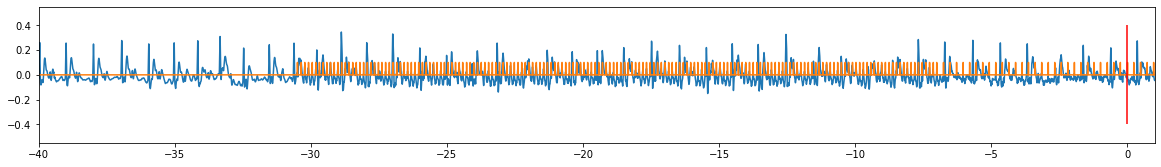

In [14]:
plt.plot(x_sec, dwi_ch_data)
plt.plot(x_sec, dwi_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-40, 1))

In [16]:
dwi_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "dwi" / f"sub-{participant}_ses-{session}_acq-highres_dir-{pe}_recording-cardiac_physio.tsv.gz"
dwi_sidecar = {
    "SamplingFrequency": channels[ch_index].samples_per_second,
    "StartTime": x_sec[0],
    "Columns": ["ecg"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "ecg": {
        "Description": "Continuous measurements of Lead I electrocardiogram",
        "Units": "mV",
        "Model": "ECG100C MRI & MECMRI-2 amplifier",
    },
}
(dwi_cardio_filepath.parent / dwi_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(dwi_sidecar, indent=2))

pd.DataFrame({"ecg": dwi_ch_data}).to_csv(
    dwi_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

Let's move on to the respiration belt.

In [18]:
dwi_resp_data = {}

ch_index = 0
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

dwi_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
dwi_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
dwi_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[dwi_idx_start:dwi_idx_stop] - dwi_onset
dwi_resp_data["belt"] = ch_data[dwi_idx_start:dwi_idx_stop]
dwi_idx_start, dwi_idx_stop, dwi_onset, x_sec[0], x_sec[-1], len(x_sec)

(704061,
 1810258,
 2883.4912681506144,
 -630.4960149016201,
 2909.3312687613366,
 1106197)

(-40.0, 1.0)

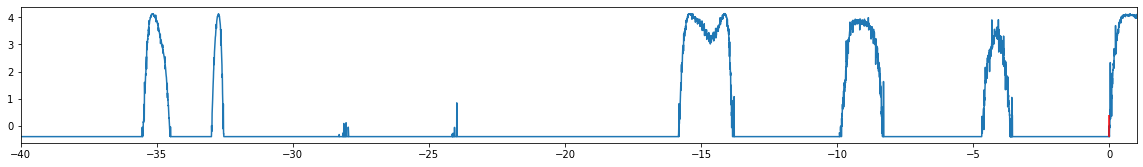

In [19]:
plt.plot(x_sec, dwi_resp_data["belt"])
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-40, 1))

In [20]:
ch_index = 2
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

dwi_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
dwi_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
dwi_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[dwi_idx_start:dwi_idx_stop] - dwi_onset
dwi_resp_data["CO2"] = ch_data[dwi_idx_start:dwi_idx_stop]
dwi_idx_start, dwi_idx_stop, dwi_onset, x_sec[0], x_sec[-1], len(x_sec)

(704061,
 1810258,
 2883.4912681506144,
 -630.4960149016201,
 2909.3312687613366,
 1106197)

(-40.0, 1.0)

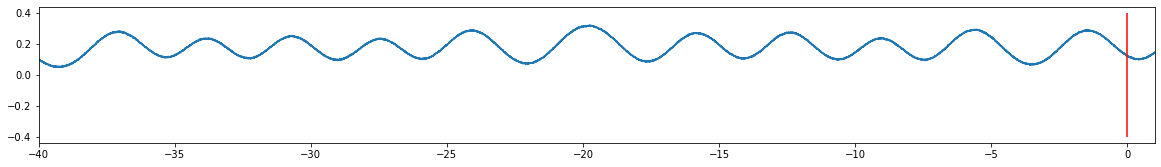

In [21]:
plt.plot(x_sec, dwi_resp_data["CO2"])
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-40, 1))

In [37]:
dwi_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "dwi" / f"sub-{participant}_ses-{session}_acq-highres_dir-{pe}_recording-respiratory_physio.tsv.gz"

dwi_sidecar = {
    "SamplingFrequency": channels[ch_index].samples_per_second,
    "StartTime": x_sec[0],
    "Columns": ["belt", "CO2"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "belt": {
        "Description": "continuous breathing measurement by differential pressure with a respiration belt",
        "Units": "cm H20",
        "Model": "DA100C TSD160A transducer",
    },
    "CO2": {
        "Description": "continuous breathing measurement: CO2 concentration over atmosphere air",
        "Units": "% concentration",
        "Model": "ML206",
        "Manufacturer": "AD Instruments Pty. Ltd., Sydney, Australia"
    }
}
(dwi_resp_filepath.parent / dwi_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(dwi_sidecar, indent=2))

pd.DataFrame(dwi_resp_data).to_csv(
    dwi_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

Finally, let's write all digital signals in a third file:

In [24]:
dwi_triggers_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "dwi" / f"sub-{participant}_ses-{session}_acq-highres_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

dwi_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

pd.DataFrame(dwi_trigger_data).to_csv(
    dwi_triggers_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

dwi_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    dwi_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
dwi_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(dwi_triggers_filepath.parent / dwi_triggers_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(dwi_sidecar, indent=2))

1518

## Converting the physio corresponding to BHT  into BIDS

In [25]:
dummies = 0

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[-1])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[-1] - 120 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = len(timeseries) - 1
t_stop = timeseries[last_timepoint]

In [26]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

bht_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
bht_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
bht_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[bht_idx_start:bht_idx_stop] - bht_onset
bht_ch_data = ch_data[bht_idx_start:bht_idx_stop]
bht_trigger = data[first_timepoint:last_timepoint]
bht_idx_start, bht_idx_stop, bht_onset, x_sec[0], x_sec[-1], len(x_sec)

(37271612,
 42310568,
 7574.32257901727,
 -120.000002836171,
 887.7910209827251,
 5038956)

(-5.0, 10.0)

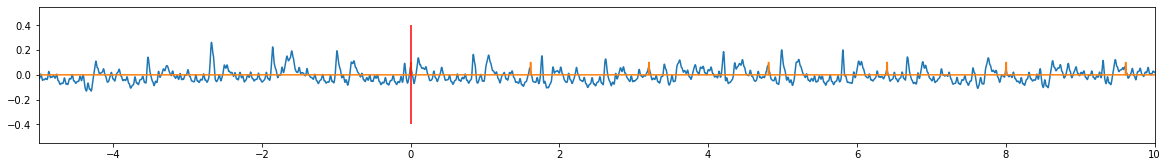

In [28]:
plt.plot(x_sec, bht_ch_data)
plt.plot(x_sec, bht_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-5, 10))

In [29]:
bht_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-bht_dir-{pe}_recording-cardiac_physio.tsv.gz"
bht_sidecar = {
    "SamplingFrequency": channels[ch_index].samples_per_second,
    "StartTime": x_sec[0],
    "Columns": ["ecg"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "ecg": {
        "Description": "Continuous measurements of Lead I electrocardiogram",
        "Units": "mV",
        "Model": "ECG100C MRI & MECMRI-2 amplifier",
    },
}
(bht_cardio_filepath.parent / bht_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(bht_sidecar, indent=2))

pd.DataFrame({"ecg": bht_ch_data}).to_csv(
    bht_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [31]:
bht_resp_data = {}

ch_index = 0
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

bht_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
bht_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
bht_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[bht_idx_start:bht_idx_stop] - bht_onset
bht_resp_data["belt"] = ch_data[bht_idx_start:bht_idx_stop]

ch_index = 2
assert channels[ch_index].samples_per_second == ch_freq
ch_data = channels[ch_index].data

bht_resp_data["CO2"] = channels[ch_index].data[bht_idx_start:bht_idx_stop]

# check values
bht_idx_start, bht_idx_stop, bht_onset, x_sec[0], x_sec[-1], len(x_sec)

(2329476,
 2644409,
 7574.323379017289,
 -120.000002836171,
 887.7824209825212,
 314933)

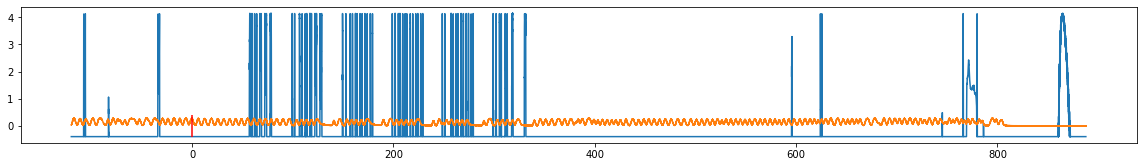

In [35]:
plt.plot(x_sec, bht_resp_data["belt"])
plt.plot(x_sec, bht_resp_data["CO2"])
plt.vlines(0, -0.4, 0.4, colors="r")

In [38]:
bht_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-bht_dir-{pe}_recording-respiratory_physio.tsv.gz"

bht_sidecar = {
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
    "Columns": ["belt", "CO2"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "belt": {
        "Description": "continuous breathing measurement by differential pressure with a respiration belt",
        "Units": "cm H20",
        "Model": "DA100C TSD160A transducer",
    },
    "CO2": {
        "Description": "continuous breathing measurement: CO2 concentration over atmosphere air",
        "Units": "% concentration",
        "Model": "ML206",
        "Manufacturer": "AD Instruments Pty. Ltd., Sydney, Australia"
    }
}
(bht_resp_filepath.parent / bht_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(bht_sidecar, indent=2))

pd.DataFrame(bht_resp_data).to_csv(
    bht_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [39]:
bht_trigg_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-bht_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

bht_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    bht_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
bht_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(bht_trigg_filepath.parent / bht_trigg_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(bht_sidecar, indent=2))

bht_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

pd.DataFrame(bht_trigger_data).to_csv(
    bht_trigg_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

## Converting the physio corresponding to RSfMRI  into BIDS

In [40]:
dummies = 0

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[-2])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[-2] - 120 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = between_seq[-1]
t_stop = timeseries[last_timepoint]

In [41]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

rest_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
rest_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
rest_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[rest_idx_start:rest_idx_stop] - rest_onset
rest_ch_data = ch_data[rest_idx_start:rest_idx_stop]
rest_trigger = data[first_timepoint:last_timepoint]
rest_idx_start, rest_idx_stop, rest_onset, x_sec[0], x_sec[-1], len(x_sec)

(30572224,
 37871612,
 6234.444947349589,
 -120.000002836171,
 1339.8774316676763,
 7299388)

(-5.0, 10.0)

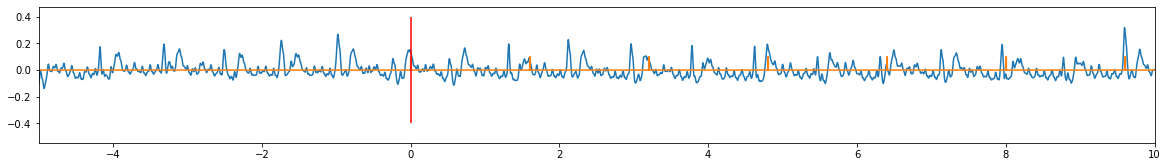

In [42]:
plt.plot(x_sec, rest_ch_data)
plt.plot(x_sec, rest_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-5, 10))

In [43]:
rest_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-rest_dir-{pe}_recording-cardiac_physio.tsv.gz"
rest_sidecar = {
    "SamplingFrequency": channels[ch_index].samples_per_second,
    "StartTime": x_sec[0],
    "Columns": ["ecg"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "ecg": {
        "Description": "Continuous measurements of Lead I electrocardiogram",
        "Units": "mV",
        "Model": "ECG100C MRI & MECMRI-2 amplifier",
    },
}
(rest_cardio_filepath.parent / rest_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(rest_sidecar, indent=2))

pd.DataFrame({"ecg": rest_ch_data}).to_csv(
    rest_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [44]:
rest_resp_data = {}

ch_index = 0
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

rest_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
rest_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
rest_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[rest_idx_start:rest_idx_stop] - rest_onset
rest_resp_data["belt"] = ch_data[rest_idx_start:rest_idx_stop]

ch_index = 2
assert channels[ch_index].samples_per_second == ch_freq
ch_data = channels[ch_index].data

rest_resp_data["CO2"] = channels[ch_index].data[rest_idx_start:rest_idx_stop]

# check values
rest_idx_start, rest_idx_stop, rest_onset, x_sec[0], x_sec[-1], len(x_sec)

(1910764,
 2366976,
 6234.444947349589,
 -120.000002836171,
 1339.8752316676246,
 456212)

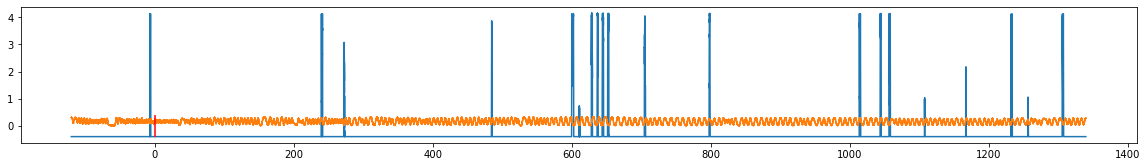

In [45]:
plt.plot(x_sec, rest_resp_data["belt"])
plt.plot(x_sec, rest_resp_data["CO2"])
plt.vlines(0, -0.4, 0.4, colors="r")

In [46]:
rest_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-rest_dir-{pe}_recording-respiratory_physio.tsv.gz"

rest_sidecar = {
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
    "Columns": ["belt", "CO2"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "belt": {
        "Description": "continuous breathing measurement by differential pressure with a respiration belt",
        "Units": "cm H20",
        "Model": "DA100C TSD160A transducer",
    },
    "CO2": {
        "Description": "continuous breathing measurement: CO2 concentration over atmosphere air",
        "Units": "% concentration",
        "Model": "ML206",
        "Manufacturer": "AD Instruments Pty. Ltd., Sydney, Australia"
    }
}
(rest_resp_filepath.parent / rest_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(rest_sidecar, indent=2))

pd.DataFrame(rest_resp_data).to_csv(
    rest_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [54]:
rest_trigg_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-rest_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

rest_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    rest_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
rest_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(rest_trigg_filepath.parent / rest_trigg_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(rest_sidecar, indent=2))

rest_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

pd.DataFrame(rest_trigger_data).to_csv(
    rest_trigg_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

## Converting the physio corresponding to QCT  into BIDS

In [49]:
dummies = 0

first_trigger = trigger_locations[np.argwhere(trigger_locations == between_seq[-3])[0, 0] + dummies]
t_0 = timeseries[first_trigger]

first_timepoint = int(between_seq[-3] - 120 * freq)
t_start = timeseries[first_timepoint]

last_timepoint = between_seq[-2]
t_stop = timeseries[last_timepoint]

(-5.0, 10.0)

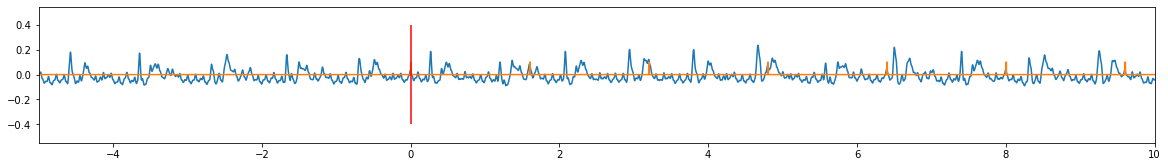

In [50]:
ch_index = 1
channels = session_data.channels
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

qct_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
qct_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
qct_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[qct_idx_start:qct_idx_stop] - qct_onset
qct_ch_data = ch_data[qct_idx_start:qct_idx_stop]
qct_trigger = data[first_timepoint:last_timepoint]

# plot it
plt.plot(x_sec, qct_ch_data)
plt.plot(x_sec, qct_trigger / 50)
plt.vlines(0, -0.4, 0.4, colors="r")
plt.xlim((-5, 10))

In [51]:
qct_cardio_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-qct_dir-{pe}_recording-cardiac_physio.tsv.gz"
qct_sidecar = {
    "SamplingFrequency": channels[ch_index].samples_per_second,
    "StartTime": x_sec[0],
    "Columns": ["ecg"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "ecg": {
        "Description": "Continuous measurements of Lead I electrocardiogram",
        "Units": "mV",
        "Model": "ECG100C MRI & MECMRI-2 amplifier",
    },
}
(qct_cardio_filepath.parent / qct_cardio_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(qct_sidecar, indent=2))

pd.DataFrame({"ecg": qct_ch_data}).to_csv(
    qct_cardio_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

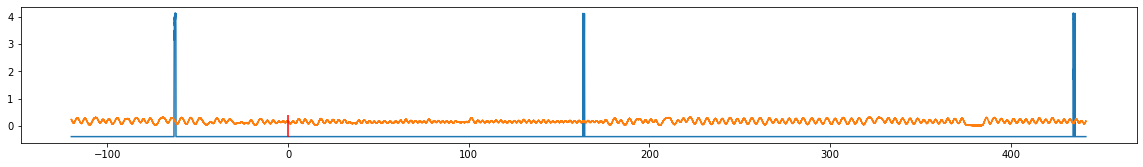

In [52]:
qct_resp_data = {}

ch_index = 0
ch_freq = channels[ch_index].samples_per_second
ch_timeseries = channels[ch_index].time_index
ch_data = channels[ch_index].data

qct_onset = ch_timeseries[(np.abs(ch_timeseries - t_0)).argmin()]
qct_idx_start = (np.abs(ch_timeseries - t_start)).argmin()
qct_idx_stop = (np.abs(ch_timeseries - t_stop)).argmin()

x_sec = ch_timeseries[qct_idx_start:qct_idx_stop] - qct_onset
qct_resp_data["belt"] = ch_data[qct_idx_start:qct_idx_stop]

ch_index = 2
assert channels[ch_index].samples_per_second == ch_freq
ch_data = channels[ch_index].data

qct_resp_data["CO2"] = channels[ch_index].data[qct_idx_start:qct_idx_stop]

plt.plot(x_sec, qct_resp_data["belt"])
plt.plot(x_sec, qct_resp_data["CO2"])
plt.vlines(0, -0.4, 0.4, colors="r")

In [53]:
qct_resp_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-qct_dir-{pe}_recording-respiratory_physio.tsv.gz"

qct_sidecar = {
    "SamplingFrequency": ch_freq,
    "StartTime": x_sec[0],
    "Columns": ["belt", "CO2"],
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
    "belt": {
        "Description": "continuous breathing measurement by differential pressure with a respiration belt",
        "Units": "cm H20",
        "Model": "DA100C TSD160A transducer",
    },
    "CO2": {
        "Description": "continuous breathing measurement: CO2 concentration over atmosphere air",
        "Units": "% concentration",
        "Model": "ML206",
        "Manufacturer": "AD Instruments Pty. Ltd., Sydney, Australia"
    }
}
(qct_resp_filepath.parent / qct_resp_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(qct_sidecar, indent=2))

pd.DataFrame(qct_resp_data).to_csv(
    qct_resp_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

In [55]:
qct_trigg_filepath = BIDS_PATH / f"sub-{participant}" / f"ses-{session}" / "func" / f"sub-{participant}_ses-{session}_task-qct_dir-{pe}_stim.tsv.gz"

channel_idx = list(range(4, len(channels)))

columns = ["trigger"] + [f"digital_ch{line}" for line in range(5, len(channels))]

qct_sidecar = {
    "SamplingFrequency": channels[4].samples_per_second,
    "StartTime": t_start - t_0,
    "Columns": columns,
    "Manufacturer": "BIOPAC Systems, Inc., Goleta, CA, US",
}

for col, chid in zip(columns, channel_idx):
    qct_sidecar[col] = {
        "Description": f"{''.join(filter(lambda x: x in string.printable, session_data.channel_headers[chid]['szCommentText'].decode().strip()))}: digital pulse signal generated with Psychopy",
        "Units": "V",
        "Model": "SPT100D",
    }
qct_sidecar["trigger"]["Description"] = "continuous measurement of the scanner trigger signal"

(qct_trigg_filepath.parent / qct_trigg_filepath.name.replace(".tsv.gz", ".json")).write_text(dumps(qct_sidecar, indent=2))

qct_trigger_data = {
    name: channels[ch_i].data[first_timepoint:last_timepoint]
    for name, ch_i in zip(columns, channel_idx)
}

pd.DataFrame(qct_trigger_data).to_csv(
    qct_trigg_filepath,
    compression="gzip",
    header=False,
    sep="\t",
    na_rep="n/a",
)

## Scraps
Some code that could become interesting some day.

In [ ]:
n_trigg_dwi = 87 * 2 + 29 + 280 * 29

first_dwi = np.argwhere(trigger_locations == between_seq[0])[0, 0]
last_dwi = trigger_locations[first_dwi + n_trigg_dwi]

seq_limits[last_dwi + int(7 * freq)] = 1

plt.plot(timeseries, trigger_onsets);
plt.plot(timeseries, seq_limits);
plt.xlim((last_dwi / freq - 70, last_dwi / freq + 28))

In [ ]:
boxcar = np.ones(round(freq * (7 / 29)) + 5)
envelope = fftconvolve(trigger_locations, boxcar)
envelope = envelope[len(boxcar) // 2:-(len(boxcar) // 2 - 1 + len(boxcar) % 2)]
plt.plot(timeseries, envelope)

In [ ]:
env_copy = envelope.copy()
env_copy[env_copy < 10] = 0
env_copy[env_copy > 0] = 1

In [ ]:
plt.plot(timeseries, env_copy)

In [ ]:
from scipy.ndimage import binary_closing

In [ ]:
amplitude = binary_closing(trigger_locations, structure=np.ones(int(freq * 1.6)))
plt.plot(timeseries, amplitude)